In [ ]:
from scipy.stats import gamma
## Step 1: Pulling in data, defining some stuff ##
# Number of draws
N1 = 800  # number of draws to keep
N0 = 200  # number of draws to drop
N = N0 + N1  # total number of draws

# Specify the size of the model
Q  = 1  # number of quarterly variables (should be fixed at 1 for now)
AR = 2  # number of lags for each individual components
M  = 9 # number of monthly variables

# Load data & transpose (following gabriel)
data_hw4 = yv
data_hw4_transpose = data_hw4.T

#data_hw4 = data_hw4.iloc[:-1, :]
y = data_hw4.values
T = y.shape[0]

In [ ]:
## Step 2: Set priors, initialise coeffs and initialise matrices for gibbs-sampling ##
# Set priors
T0 = np.array([0, 0])  # For PHI1, PHI2 of common component
R0 = np.eye(2)
T0p = np.zeros(AR)
R0p = np.eye(AR)
T00 = 0
R00 = 1
V0 = 0
D0 = 0.1 * (V0 - 1)

# More initial values
PHI1TT = 0.6
PHI2TT = 0.1
SIG2FTT = 1
LAM_TT = np.concatenate((np.ones(Q), np.ones(M) * 0.5)) # initial values for the factor loadings (1 for GDP, 0.5 for all other variables)
PSI_TT = np.concatenate((np.ones(Q * AR) * 0.2, np.ones(M * AR) * 0.2)) # initial values for the AR coefficients of the idiosyncratic components
SIG2_TT = np.ones(Q + M) * 0.1 # initial values for the variances of the idiosyncratic components

# Initialise for Gibbs sampling
lamda = np.zeros((Q + M, N - N0))
FMM = np.zeros((T, N - N0)) 
SIG2FMM = np.zeros((1, N - N0))
fore2 = np.zeros((T, N - N0))

In [ ]:
def GEN_ZT_MS_dll(yy, lam, psi, sig2, sig2f, index, Q, M, AR, phi1, phi2):
    data = yy.T
    T = data.shape[1]
    Ny = yy.shape[0]  # number of variables
    Ns = 35  # adjusted for your model

    th = np.concatenate([lam, [phi1], [phi2], psi, sig2])
    RR, QQ, H, F = build_matrices(th)

    beta00 = np.zeros(Ns)
    P00 = np.eye(Ns)

    filter = np.zeros((T, Ns))
    chorizo = np.zeros((Ns, Ns, T))

    for ii in range(T):
        valid_index = index.iloc[ii, :].to_numpy()  # Get valid indices for the current time step
        if valid_index.any():  # Only process if there is at least one valid observation
            # Masking H matrix (so setting rows to zero where observations are missing)
            Hit = H[valid_index, :]

            # Masking R matrix (so setting diagonal elements to zero where observations are valid)
            Rit = RR[np.ix_(valid_index, valid_index)]

            y = data.iloc[:, ii].to_numpy()[valid_index]  # Masking data array with valid_index

            beta10 = np.dot(F, beta00)
            P10 = np.dot(np.dot(F, P00), F.T) + QQ

            nu = y - np.dot(Hit, beta10)  # conditional forecast error
            F10 = np.dot(np.dot(Hit, P10), Hit.T) + Rit  # variance of the conditional forecast error
            OMinv = np.linalg.inv(F10)

            beta11 = beta10 + np.dot(np.dot(P10, Hit.T), np.dot(OMinv, nu))
            P11 = P10 - np.dot(np.dot(P10, Hit.T), np.dot(OMinv, Hit).dot(P10))

            beta00 = beta11
            P00 = P11
            filter[ii, :] = beta11
            chorizo[:, :, ii] = P11

    yhat_corr = np.dot(filter, H[0, :])

    # Draw Sdraw(T|T) ~ N(S(T|T),P(T|T))
    Zdraw = np.zeros((T, Ns))
    Zdraw[-1, :] = np.random.multivariate_normal(beta11, P11)

    km = [0] + list(range(6, 6 + 5 * Q, 5)) + list(range(5 + 5 * Q + 1, 5 + 5 * Q + AR * M + 1, AR))

    # Iterate down, drawing at each step
    Qstar = QQ[np.ix_(km, km)]
    Fstar = F[np.ix_(km, range(Ns))]

    for ii in range(T - 2, -1, -1):
        Zf = Zdraw[ii + 1, km]
        Ztt = filter[ii, :]
        Ptt = chorizo[:, :, ii]

        OM = np.dot(Fstar, np.dot(Ptt, Fstar.T)) + Qstar
        OMinv = np.linalg.inv(OM)
        nu = Zf - np.dot(Fstar, Ztt)

        Zmean = Ztt + np.dot(np.dot(Ptt, Fstar.T), np.dot(OMinv, nu))
        Zvar = Ptt - np.dot(np.dot(Ptt, Fstar.T), np.dot(OMinv, Fstar).dot(Ptt))

        Zdraw[ii, :] = np.random.multivariate_normal(Zmean, Zvar)

    Fdraw = Zdraw

    return Fdraw, yhat_corr

In [ ]:
# (3.2)
def GEN_PHI(ztt, Sigma0, B0):
    # Helper function for lagging (only 2 lag as AR2)
    def lag0(arr, lag):
        result = np.zeros_like(arr)
        if lag > 0:
            result[lag:] = arr[:-lag]
        return result

    Y = ztt
    X = np.column_stack((lag0(Y, 1), lag0(Y, 2)))

    # Remove missing obs (drop first 2 elements for lags)
    Y = Y[2:]
    X = X[2:, :]

    sigma2 = 1  #normalise variance

    # Sample B conditional on sigma N(M*, V*)
    XtX = np.dot(X.T, X)
    Sigma0_inv = np.linalg.inv(Sigma0)
    M = np.dot(np.linalg.inv(Sigma0 + (1 / sigma2) * XtX),
               (np.dot(Sigma0_inv, B0) + (1 / sigma2) * np.dot(X.T, Y)))
    V = np.linalg.inv(Sigma0 + (1 / sigma2) * XtX)
    chck = -1

    while chck < 0:  # Check for stability
        B = M + np.dot(np.random.randn(2), np.linalg.cholesky(V))
        B = B.flatten()  # Ensure B is a 1D array
        print(f"B sampled: {B}")  # Debugging statement
        b = np.array([[B[0], B[1]], [1, 0]])
        print(f"Matrix b: {b}")  # ensuring we got stationarity)
        ee = np.max(np.abs(np.linalg.eigvals(b)))
        if ee <= 1:
            chck = 1

    B1 = B[0]
    B2 = B[1]

    return B1, B2

In [ ]:
def delif(arr, mask):
    return arr[mask]

def GEN_LAMDA_MIX_Q_WN_mis(ndx, yyy, z, sigma2, Sigma0, B0, index0):
    # extract relevant series and transpose it
    yy = yyy.iloc[ndx, :].values.reshape(-1, 1)  # Ensure yy is a 2D array with shape (n, 1)
    y = yy[4:, :]

    # Create the lagged factor series
    f0 = z[4:]
    f1 = z[3:-1]
    f2 = z[2:-2]
    f3 = z[1:-3]
    f4 = z[:-4]

    # Construct the regressor matrix X
    X = (1/3) * f0 + (2/3) * f1 + f2 + (2/3) * f3 + (1/3) * f4

    # Adjust the index for valid observations
    index = index0.iloc[4:, :].values  # Adjust to slice along the correct axis

    # Valid mask for observations corresponding to the GDP series
    valid_mask = index[:, ndx] == 1  # Valid data points are marked with 1

    # Debugging output (FIXED). was getting issues with shapes not being able to do dot products or inv.
    print(f"Original y shape: {yy.shape}")
    print(f"Filtered y shape: {y.shape}")
    print(f"X shape: {X.shape}")
    print(f"index shape: {index.shape}")
    print(f"valid_mask shape: {valid_mask.shape}")
    print(f"valid_mask: {valid_mask}")

    # Apply the valid mask
    y = delif(y, valid_mask)
    X = delif(X, valid_mask)

    print(f"Filtered y shape after mask: {y.shape}")
    print(f"Filtered X shape after mask: {X.shape}")

    Sigma2 = sigma2 * (19/9)
    XtX = np.dot(X.T, X)
    Sigma0_inv = 1 / Sigma0

    M = np.dot(1 / (Sigma0 + (1 / Sigma2) * XtX),
               (Sigma0_inv * B0 + (1 / Sigma2) * np.dot(X.T, y)))
    V = 1 / (Sigma0 + (1 / Sigma2) * XtX)

    # Sample from the posterior distribution
    B = M + (np.random.randn() * np.sqrt(V)) #cholev

    return B

In [ ]:
def GEN_LAMDA_MIX(ndx, yyy, zzz, psi, sigma2, Sigma0, B0, index, AR):
    yy0 = yyy.iloc[:, ndx].to_numpy().T  #transpose
    yy = delif(yy0, 1 - index.iloc[:, ndx].to_numpy())
    ztt = delif(zzz, 1 - index.iloc[:, ndx].to_numpy())

    Y = yy[AR:]
    X = ztt[AR:]
    for ii in range(1, AR + 1):
        Y -= psi[ii - 1] * yy[AR - ii:-ii]
        X -= psi[ii - 1] * ztt[AR - ii:-ii]
    
    Sigma2 = sigma2
    XtX = np.dot(X.T, X)
    
    Sigma0_inv = 1 / Sigma0
    M = (Sigma0_inv + (1 / Sigma2) * XtX) ** -1 * (Sigma0_inv * B0 + (1 / Sigma2) * np.dot(X.T, Y))
    V = (Sigma0_inv + (1 / Sigma2) * XtX) ** -1

    B = M + np.random.randn(1) * np.sqrt(V)

    return B

# Define the delif function to handle missing data based on index
def delif(arr, mask):
    return arr[mask == 0]

In [ ]:
def GEN_SIG_MIX_Q(ndx, zzz, T0, D0, index):
    zz = zzz[:, ndx]
    valid_index = index.iloc[:, ndx].values
    Y = delif(zz, 1 - valid_index)
    T = Y.shape[0]

    # Sample sigma2 conditional on B from IG(T0 + T/2, D0 + (resids.T @ resids) / 2)
    resids = Y
    shape = T0 + T / 2
    scale = 1 / (D0 + (resids.T @ resids) / 2)
    sigma2 = 1 / gamma.rvs(shape, scale=scale)
    
    return sigma2

# Define the delif for missing data based on index (same as usual)
def delif(arr, mask):
    return arr[mask == 0]

In [ ]:
def GEN_PSI_SIG_MIX(ndx, zzz, sigma2, Sigma0, B0, T0, D0, index, AR):
    def lag0(arr, lag):
        result = np.zeros_like(arr)
        if lag > 0:
            result[lag:] = arr[:-lag]
        return result

    zz = zzz[:, ndx]  # Extracting just the relevant column
    valid_index = index.iloc[:, ndx].values
    Y = delif(zz, 1 - valid_index)  # Applying our delif function

    #print(f"zz shape: {zz.shape}, valid_index shape: {valid_index.shape}, Y shape after delif: {Y.shape}")

    X = np.zeros((len(Y), AR))
    for ii in range(AR):
        X[:, ii] = lag0(Y, ii + 1)

    #print(f"X shape before removing missing observations: {X.shape}")

    # Remove missing obs
    Y = Y[AR:]
    X = X[AR:, :]
    T = X.shape[0]

    #print(f"Y shape after removing missing observations: {Y.shape}, X shape after removing missing observations: {X.shape}, T: {T}")

    # Sample B conditional on sigma N(M*,V*)
    XtX = np.dot(X.T, X)
    if np.linalg.matrix_rank(Sigma0) < Sigma0.shape[0]:
        Sigma0_inv = np.linalg.pinv(Sigma0)
        print("Using pseudo-inverse for Sigma0")
    else:
        Sigma0_inv = np.linalg.inv(Sigma0)
    M = np.dot(np.linalg.inv(Sigma0 + (1 / sigma2) * XtX), 
               (np.dot(Sigma0_inv, B0) + (1 / sigma2) * np.dot(X.T, Y)))
    V = np.linalg.inv(Sigma0 + (1 / sigma2) * XtX)

    #print(f"XtX shape: {XtX.shape}, Sigma0_inv: {Sigma0_inv}, M shape: {M.shape}, V shape: {V.shape}")

    chck = -1

    while chck < 0:  # Check for stability
        B = M + (np.random.randn(AR) @ np.linalg.cholesky(V)).T
        B = B.reshape(-1)  # Ensure B is a row vector
        b = np.vstack([B, np.hstack([np.eye(AR - 1), np.zeros((AR - 1, 1))])])
        ee = np.max(np.abs(np.linalg.eigvals(b)))
        if ee <= 1:
            chck = 1

    #print(f"B shape: {B.shape}, b shape: {b.shape}, ee: {ee}")

    # Sample sigma2 conditional on B from IG(T1, D1)
    resids = Y - np.dot(X, B)
    shape = T0 + T / 2
    scale = 1 / (D0 + (np.dot(resids.T, resids) / 2))

    print(f"resids shape: {resids.shape}, shape: {shape}, scale: {scale}")

    if scale <= 0:
        raise ValueError(f"Scale parameter must be positive, but got {scale}")

    sigma2 = 1 / gamma.rvs(shape, scale=scale)

    print(f"sigma2: {sigma2}")

    return B, sigma2  # Ensure B is returned as a 1-dimensional array

# Define the delif function to handle missing data based on index
def delif(arr, mask):
    return arr[mask == 0]

# Running the Gibbs Sampling & plotting factor + GDP estimates

Iteration: 1
B sampled: [0.48864243 0.01589692]
Matrix b: [[0.48864243 0.01589692]
 [1.         0.        ]]
Original y shape: (161, 1)
Filtered y shape: (157, 1)
X shape: (157,)
index shape: (157, 10)
valid_mask shape: (157,)
valid_mask: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True 

/var/folders/4x/mvrhm6ks0ql5m2wsdb_v91sh0000gn/T/ipykernel_40677/4077815705.py:46: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Zdraw[-1, :] = np.random.multivariate_normal(beta11, P11)
/var/folders/4x/mvrhm6ks0ql5m2wsdb_v91sh0000gn/T/ipykernel_40677/4077815705.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Zdraw[ii, :] = np.random.multivariate_normal(Zmean, Zvar)


B sampled: [0.35985513 0.04287994]
Matrix b: [[0.35985513 0.04287994]
 [1.         0.        ]]
Original y shape: (161, 1)
Filtered y shape: (157, 1)
X shape: (157,)
index shape: (157, 10)
valid_mask shape: (157,)
valid_mask: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  

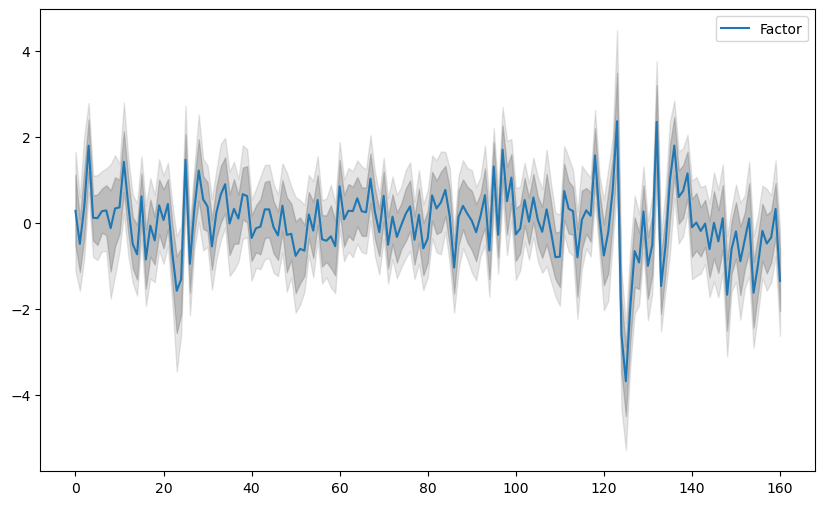

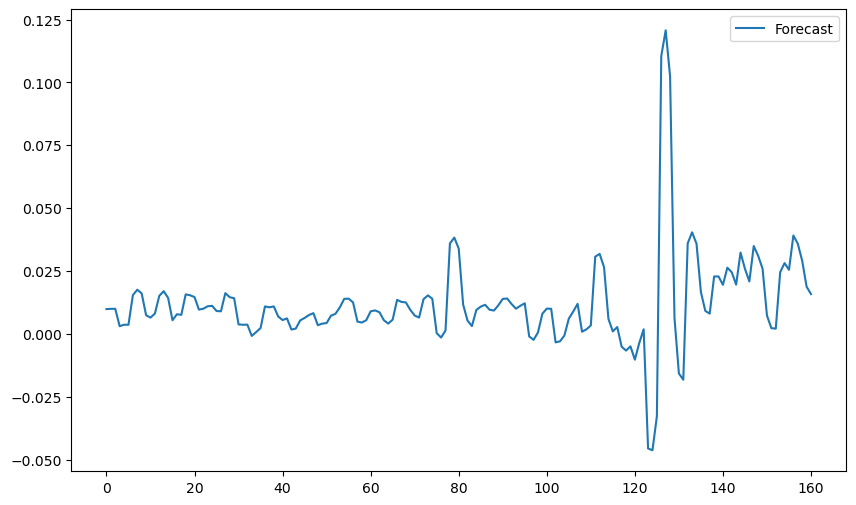

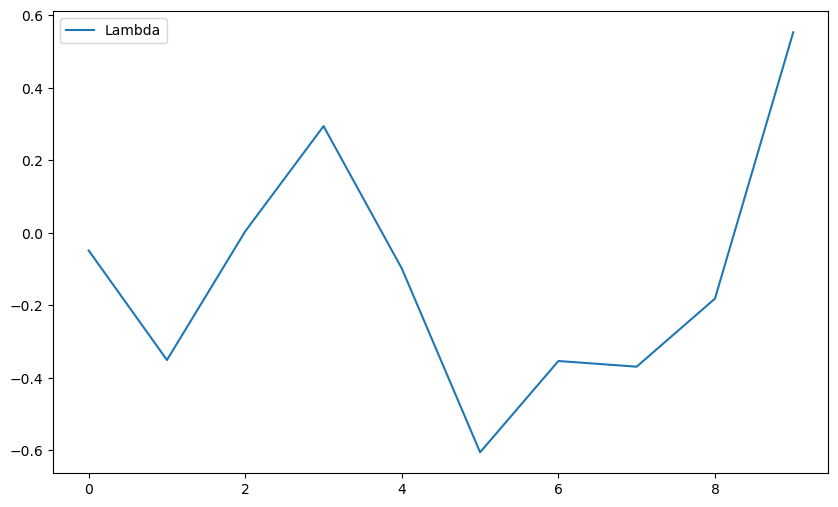

In [ ]:
# GIBBS SAMPLING:
for itr in range(N):
    print(f'Iteration: {itr + 1}')
    
    # Step 1: Draw Z, common and individual components conditional on Y, X, S
    ZTTALL, YHAT = GEN_ZT_MS_dll(data_hw4, LAM_TT, PSI_TT, SIG2_TT, SIG2FTT, index, Q, M, AR, PHI1TT, PHI2TT)
    FTT = ZTTALL[:, 0]  # Common factor
    PHI1TT, PHI2TT = GEN_PHI(FTT, R0, T0)
    
    ITT_indices = list(range(6, 6 + 5 * Q, 5)) + list(range(6 + 5 * Q, 6 + 5 * Q + AR * M, AR))
    ITT = ZTTALL[:, ITT_indices]
    
    YHAT2 = YHAT * std_devs[0] + means[0]
     
    # Step 2: Draw factor loadings
    LAM_TT[0] = GEN_LAMDA_MIX_Q_WN_mis(1, data_hw4_transpose, FTT, SIG2_TT[0], R00, T00, index)
    for iiv in range(M):
        LAM_TT[Q + iiv] = GEN_LAMDA_MIX(Q + iiv, data_hw4, FTT, PSI_TT[AR * Q + AR * iiv:AR * Q + AR * (iiv + 1)], SIG2_TT[Q + iiv], R00, T00, index, AR)
    
    # Step 3: Draw AR coeffs and variances of idiosyncratic terms
    for iiv in range(Q):
        SIG2_TT[iiv] = GEN_SIG_MIX_Q(iiv, ITT, V0, D0, index)
    
    for iiv in range(M):
        PSI_TT[AR * Q + AR * iiv:AR * Q + AR * (iiv + 1)], SIG2_TT[Q + iiv] = GEN_PSI_SIG_MIX(Q + iiv, ITT, SIG2_TT[Q + iiv], R0p, T0p, V0, D0, index, AR)
    
    # Collect generated draws
    if itr >= N0:
        lamda[:, itr - N0] = LAM_TT
        FMM[:, itr - N0] = FTT
        SIG2FMM[:, itr - N0] = SIG2FTT
        fore2[:, itr - N0] = YHAT2

# Compute medians and percentiles
FACTOR = np.median(FMM, axis=1)
FACTOR_bands = np.percentile(FMM, [5, 16, 84, 95], axis=1)
forecastfin = np.median(fore2, axis=1)
caca = np.median(lamda, axis=1)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(FACTOR, label='Factor')
plt.fill_between(range(T), FACTOR_bands[0], FACTOR_bands[3], color='gray', alpha=0.2)
plt.fill_between(range(T), FACTOR_bands[1], FACTOR_bands[2], color='gray', alpha=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(forecastfin, label='Forecast')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(caca, label='Lambda')
plt.legend()
plt.show()

# Plotting the variables and the factor

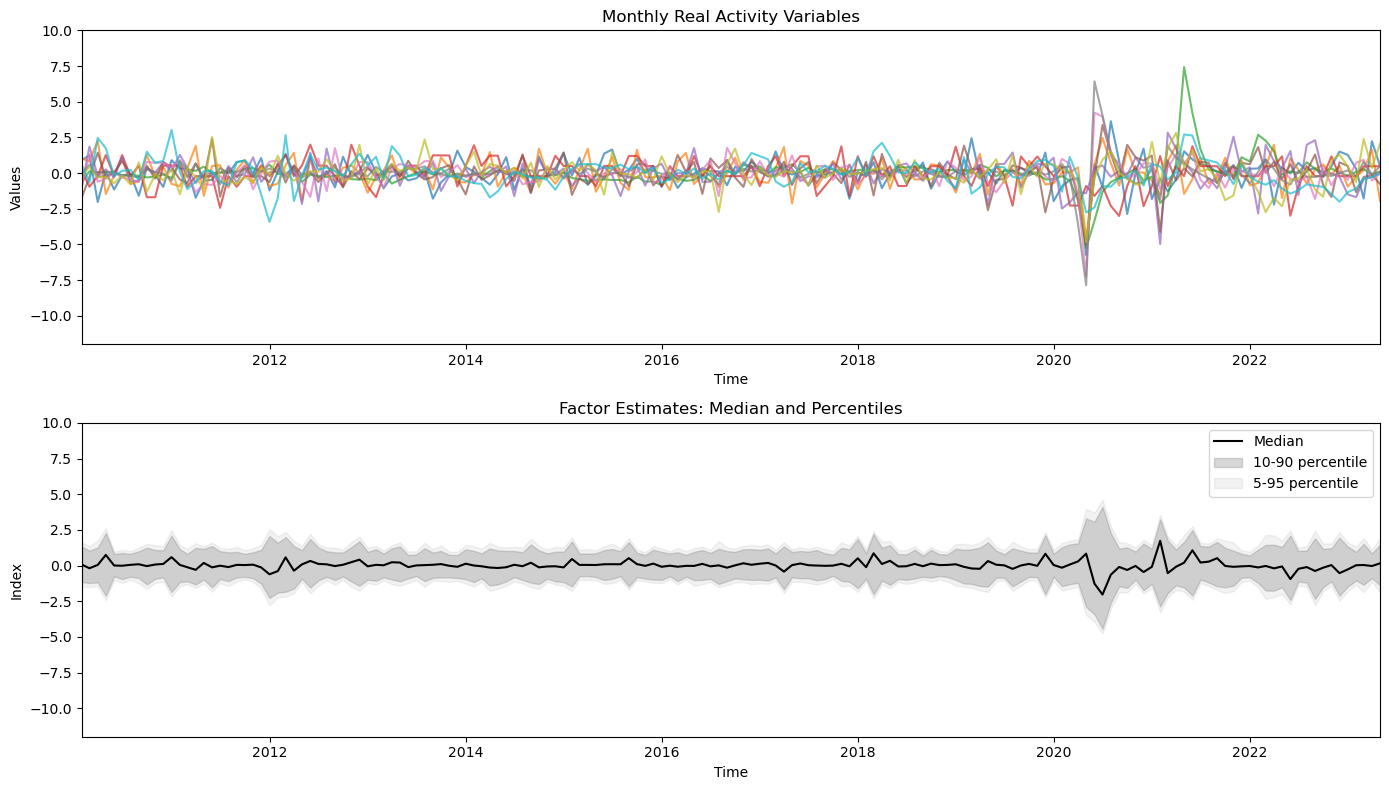

In [ ]:
time = pd.date_range(start='2010-01-01', end='2023-05-01', freq='M')

# Ensuring time and data have the same length
time = time[:len(data_hw4)]
data_hw4 = data_hw4.iloc[:len(time), :]
FMM = FMM[:len(time), :] #just ensuring lens match up

# Plot variables and factor
plt.figure(figsize=(14, 8))

# Plot our monthly variables
plt.subplot(2, 1, 1)
for col in range(data_hw4.shape[1]):
    plt.plot(time, data_hw4.iloc[:, col], alpha=0.7)
plt.ylim([-12, 10])
plt.xlim([time[0], time[-1]])
plt.title('Monthly Real Activity Variables')
plt.xlabel('Time')
plt.ylabel('Values')

# Plot factor
plt.subplot(2, 1, 2)
plt.plot(time, np.percentile(FMM, 50, axis=1), '-k', label='Median')
plt.fill_between(time, np.percentile(FMM, 10, axis=1), np.percentile(FMM, 90, axis=1), color='gray', alpha=0.3, label='10-90 percentile')
plt.fill_between(time, np.percentile(FMM, 5, axis=1), np.percentile(FMM, 95, axis=1), color='gray', alpha=0.1, label='5-95 percentile')
plt.title('Factor Estimates: Median and Percentiles')
plt.xlim([time[0], time[-1]])
plt.ylim([-12, 10])
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()

plt.tight_layout()
plt.show()